In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set_style("darkgrid")

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read bank dataset
df_bank = pd.read_csv('/content/drive/MyDrive/TimeSeries/megabank_stock.csv', index_col=0)
df_bank.index = pd.to_datetime(df_bank.index)
df_bank.head()

,Adj Close BAC,Adj Close GS,Adj Close HSBC,Adj Close JPM,Adj Close MS,Adj Close RY,Adj Close TD,Adj Close WFC,Close BAC,Close GS,...,Open TD,Open WFC,Volume BAC,Volume GS,Volume HSBC,Volume JPM,Volume MS,Volume RY,Volume TD,Volume WFC
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,21.949945,52.764973,20.656130,14.395320,23.272638,8.531053,5.087502,13.742735,35.340000,69.650002,...,10.875,23.575001,12584000,4025400,1081700,16739100,4310700,75400,86200,9904200
2003-01-03,21.813301,53.317997,20.902828,14.678248,23.228249,8.627298,5.147490,13.550333,35.119999,70.379997,...,11.075,24.025000,7803400,2342800,1114900,12525700,2963100,101400,120800,7808000
2003-01-06,22.126961,55.302856,21.109016,15.832584,23.855307,8.746449,5.242086,13.819124,35.625000,73.000000,...,11.155,23.900000,12500600,4337600,2100600,22932400,4167300,312000,71800,8097400
2003-01-07,22.161121,55.075584,20.766588,15.753373,23.982925,8.734997,5.216707,13.734243,35.680000,72.699997,...,11.360,24.424999,9804800,4606900,1609100,17837500,5213800,234200,85800,6556200
2003-01-08,22.071058,53.727081,20.692965,15.147902,23.386003,8.485226,5.156716,13.539013,35.535000,70.919998,...,11.295,24.275000,8487600,3265200,889000,15857300,4054600,178000,77000,8071000


In [5]:
# select columns relevant to JPM
df_jpm = df_bank[['Adj Close JPM']]
df_jpm.rename(columns={"Adj Close JPM": "jpm_price"}, inplace=True)
# check df infomation
df_jpm.info()
# look at df
display(df_jpm)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5097 entries, 2003-01-02 to 2023-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   jpm_price  5097 non-null   float64
dtypes: float64(1)
memory usage: 79.6 KB


<ipython-input-5-8fb7545deb72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jpm.rename(columns={"Adj Close JPM": "jpm_price"}, inplace=True)


,jpm_price
Date,
2003-01-02,14.395320
2003-01-03,14.678248
2003-01-06,15.832584
2003-01-07,15.753373
2003-01-08,15.147902
...,...
2023-03-27,127.489464
2023-03-28,127.876427
2023-03-29,128.134399


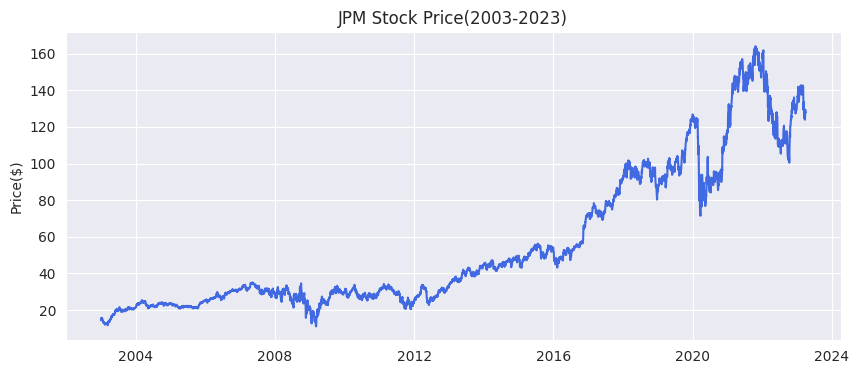

In [8]:
# plot JPM price
plt.figure(figsize = (10, 4))
sns.lineplot(x=df_jpm.index, y=df_jpm['jpm_price'], color = 'royalblue')
plt.title('JPM Stock Price(2003-2023)')
plt.ylabel('Price($)')
plt.xlabel(None)
plt.show()

Selecting time period of interest which is after 2008 financial crisis when the market returned to normal.

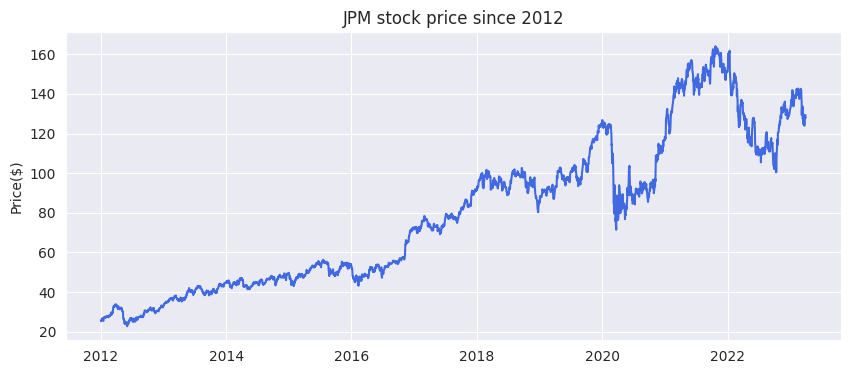

In [10]:
# select periods since 2012
df_jpm = df_jpm['2012-01-01':]

# plot again
plt.figure(figsize = (10, 4))
sns.lineplot(x=df_jpm.index, y=df_jpm['jpm_price'], color = 'royalblue')
plt.title('JPM stock price since 2012')
plt.ylabel('Price($)')
plt.xlabel(None)
plt.show()

In [13]:
# Convert the dataframe to a numpy array
dataset = df_jpm.values

# dataset2 = np.array(jpm_recent['Adj Close JPM'])

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .90 ))

training_data_len

2547

In [14]:
dataset

array([[ 25.34964752],
       [ 25.5102272 ],
       [ 26.04306221],
       ...,
       [128.13439941],
       [127.74743652],
       [129.29528809]])

In [15]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

# scaled_data2 = scaler.fit_transform(jpm_recent[['Adj Close JPM']])
# scaled_data2

array([[0.01822729],
       [0.01936422],
       [0.02313675],
       ...,
       [0.74595573],
       [0.74321599],
       [0.75417496]])

In [16]:
train_data = scaled_data[0:training_data_len]

In [17]:
train_data.shape

(2547, 1)

In [18]:
# sliding window
SEQUENCE_LENGTH = 60

X_train = []
y_train = []

for window_start_idx in range(len(train_data)-SEQUENCE_LENGTH):
    window_end_idx = window_start_idx + SEQUENCE_LENGTH
    X_train.append(train_data[window_start_idx: window_end_idx, 0])
    y_train.append(train_data[window_end_idx, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Let's look at the shapes
print(X_train.shape)
print(y_train.shape)

(2487, 60)
(2487,)


In [19]:
print(X_train[0])
print(y_train[0])

[0.01822729 0.01936422 0.02313675 0.02148302 0.02117294 0.02504883
 0.02820113 0.02918315 0.02437705 0.01915749 0.0275811  0.0295965
 0.03181869 0.03336904 0.03336904 0.03305901 0.0324905  0.03104358
 0.03000989 0.03150864 0.03305901 0.03280055 0.03657311 0.03584961
 0.03445433 0.0366765  0.03440262 0.03311063 0.0366765  0.03471274
 0.03202542 0.0351261  0.037555   0.03750331 0.03548791 0.03765839
 0.03657311 0.04060408 0.04137915 0.04153417 0.04737388 0.04871744
 0.04752887 0.04194766 0.04520332 0.04773554 0.05078457 0.04825242
 0.06298067 0.06396249 0.06975052 0.06907868 0.07130089 0.07326468
 0.07192106 0.06949221 0.0721277  0.07734721 0.07590025 0.07786407]
0.07476332841940381


In [20]:
# random seeds for reproducibility
tf.random.set_seed(123)

# model setup
RNN_model = Sequential()

RNN_model.add(LSTM(128, return_sequences=True, input_shape = (X_train.shape[1], 1)))
RNN_model.add(LSTM(64, return_sequences=False))

RNN_model.add(Dense(32))
RNN_model.add(Dense(1))

# Compile model
RNN_model.compile(
    loss='mean_squared_error',
    optimizer=Adam(learning_rate=0.001)
)

# Display its summary
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [21]:
RNN_history = RNN_model.fit(X_train, y_train,
                            batch_size=1,
                            epochs=2)

Epoch 1/2
2487/2487 [==============================] - 113s 44ms/step - loss: 0.0015
Epoch 2/2
2487/2487 [==============================] - 110s 44ms/step - loss: 5.7924e-04


In [22]:
RNN_history.history

{'loss': [0.001526528038084507, 0.0005792445153929293]}

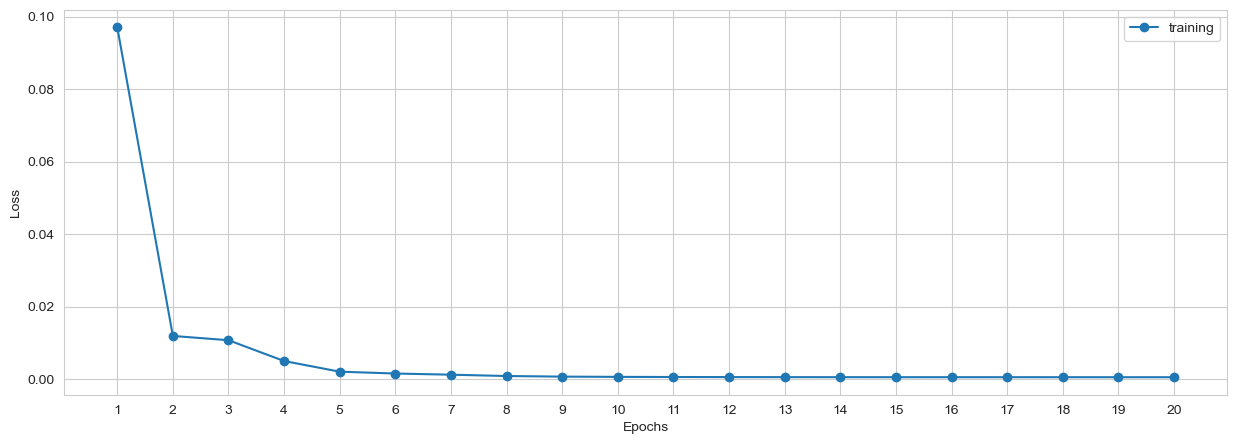

In [ ]:
# epochs = range(1, 21)

# plt.figure(figsize=(15, 5))

# plt.plot(epochs, RNN_history.history["loss"], label="training", marker="o")
# plt.xlabel("Epochs")
# plt.xticks(epochs)
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [25]:
# Create the testing data set
# Create a new array containing scaled values from index 2607 to 2807 
test_data = scaled_data[training_data_len-SEQUENCE_LENGTH: , :]
test_data.shape

(343, 1)

In [26]:
# creating test set

X_test = []

for window_start_idx in range(len(test_data)-SEQUENCE_LENGTH):
    window_end_idx = window_start_idx + SEQUENCE_LENGTH
    X_test.append(test_data[window_start_idx: window_end_idx, 0])

X_test = np.array(X_test)

print(X_test.shape)


(283, 60)


In [27]:
y_test = dataset[training_data_len:, :]
y_test.shape

(283, 1)

In [28]:
# Get the models predicted price values 
predictions = RNN_model.predict(X_test)

9/9 [==============================] - 1s 41ms/step


In [29]:
# convert back to unscaled data
predictions = scaler.inverse_transform(predictions)
predictions.shape

(283, 1)

In [30]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2.566219845990309

In [31]:
# Plot the data
train_lstm = df_jpm[:training_data_len]
test_lstm = df_jpm[training_data_len:]
test_lstm['Predictions'] = predictions


<ipython-input-31-8bbff9857670>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_lstm['Predictions'] = predictions


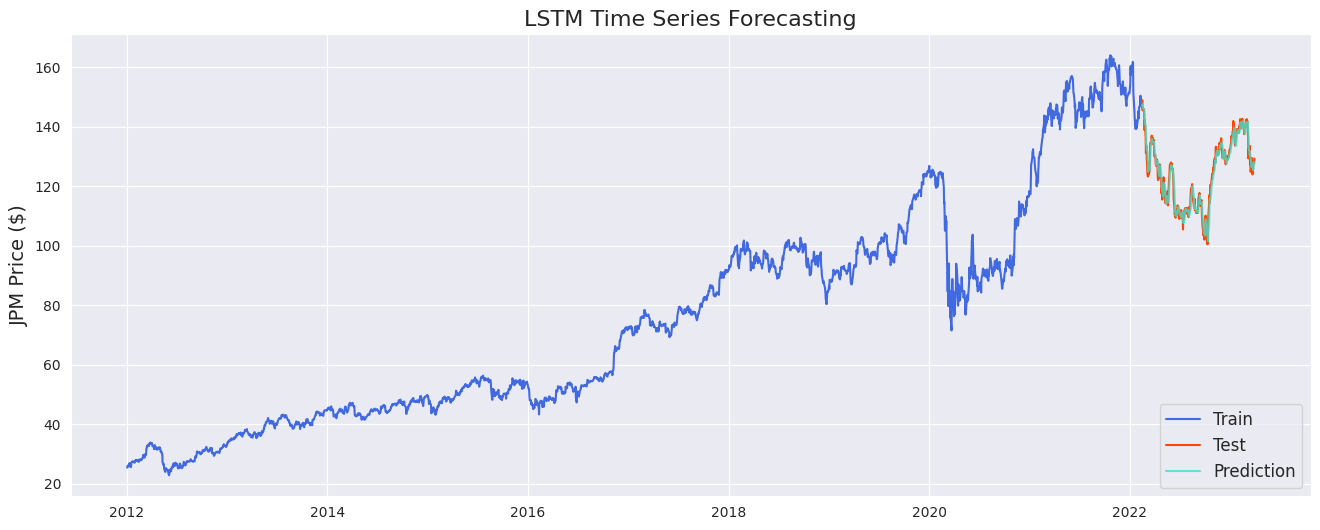

In [33]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.plot(train_lstm['jpm_price'], color = 'royalblue', label = 'Train')
plt.plot(test_lstm['jpm_price'], color = 'orangered', label = 'Test')
plt.plot(test_lstm['Predictions'], color = 'turquoise', label = 'Prediction', alpha=0.8)
plt.title('LSTM Time Series Forecasting', fontsize=16)
plt.xlabel(None)
plt.ylabel('JPM Price ($)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()